In [1]:
import os

# Data loading and preparing

In [2]:
import sys
scripts_dir = os.path.join(os.path.dirname(os.path.abspath('')), 'scripts')
models_dir = os.path.join(os.path.dirname(os.path.abspath('')), 'models')

if not scripts_dir in sys.path:
    sys.path.append(scripts_dir)

if not models_dir in sys.path:
    sys.path.append(models_dir)

In [34]:
from past_present_train_test_split import prepare_training_data
from CitationRateEncoder import CitationRateEncoder

g, df, (train, test) = prepare_training_data()
df = df.drop(columns=['Date', 'Title', 'Authors', 'Abstract'])
df.head()

,Paper_ID,target_citation_rate
0,9511170,0.0
1,9211024,0.0
2,9806180,9.0
5,9503176,3.0
6,9611143,0.0


In [35]:
n_classes = 4
n_layers = 3
n_epochs = 500
random_emb_size = 64
hidden_dim = 256
crop_df = True
encoder = CitationRateEncoder(n_classes)
encoder.fit(g)

<Axes: >

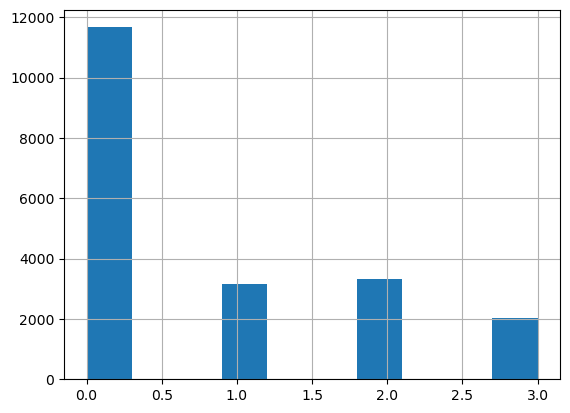

In [36]:
df['target'] = encoder.transform(df['target_citation_rate'])
df['target'].hist()

In [37]:
def crop_data(df):
    mn = df[df['Paper_ID'].isin(train)]['target'].value_counts().min()
    for target in df['target'].unique():
        condition = (df['target'] == target) & (df['Paper_ID'].isin(train))
        to_drop = len(df[condition]) - mn
        ids_to_drop = df[condition].sample(n=to_drop).index
        df.drop(ids_to_drop, inplace=True)

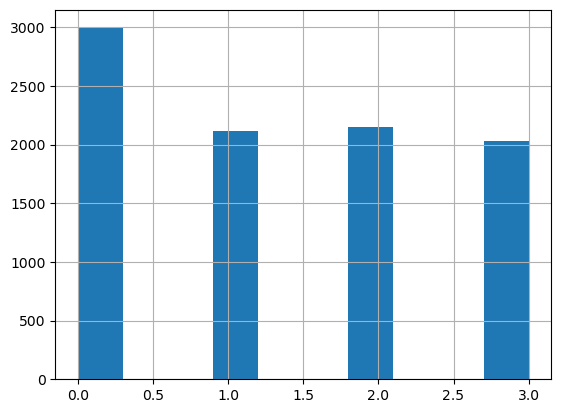

In [38]:
paper_id2emb_id = {elem: i for i, elem in enumerate(df['Paper_ID'])}
if crop_df:
    crop_data(df)
    df['target'].hist()

In [8]:
import dgl
import networkx as nx

nx.set_node_attributes(g, {node: node for node in g.nodes()}, "ID")
G = dgl.from_networkx(g, node_attrs=['ID'])
nx2dgl = {key: val for key, val in zip(G.ndata['ID'].tolist(), G.nodes().tolist())}

/home/yvovaa/anaconda3/envs/sna/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
G = G.add_self_loop()

In [10]:
import torch

counts = sorted(df['target'].value_counts().items(), key=lambda  x: x[0])
weights = torch.tensor([1 / val[1] for val in counts])
weights /= weights.sum()

In [11]:
from random import sample

train_labels = df[df['Paper_ID'].isin(train)]
test_labels = df[df['Paper_ID'].isin(test)]

In [12]:
y_test = sample(test, len(test) // 2)
y_val = list(set(test) - set(y_test))

In [13]:
train_mask = torch.tensor([nx2dgl[node] for node in train_labels['Paper_ID']])
test_mask = torch.tensor([nx2dgl[node] for node in y_test])
val_mask = torch.tensor([nx2dgl[node] for node in y_val])

In [14]:
y_train = torch.LongTensor(train_labels['target'])
y_test = torch.LongTensor([test_labels[test_labels['Paper_ID'] == elem]['target'].tolist()[0] for elem in y_test])
y_val = torch.LongTensor([test_labels[test_labels['Paper_ID'] == elem]['target'].tolist()[0] for elem in y_val])

# Training utils

In [15]:
def run_epoch(G, features, train_labels, test_labels, model, train_mask, test_mask, optimizer, loss_fn):
    model.train()

    optimizer.zero_grad()

    logits = model(G, features)

    train_loss = loss_fn(logits[train_mask], train_labels)
    pred_labels = torch.argmax(logits, dim=-1)
    train_acc = (pred_labels[train_mask] == train_labels).sum() / len(train_mask)

    train_loss.backward()
    optimizer.step()

    with torch.no_grad():
        val_loss = loss_fn(logits[test_mask], test_labels)
        val_acc = (pred_labels[test_mask] == test_labels).sum() / len(test_mask)

    return train_loss.item(), train_acc.item(), val_loss.item(), val_acc.item()

In [16]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def plot_curves(train_loss, train_acc, val_loss, val_acc):
    fig = plt.figure(figsize=(12, 9))

    ax1 = plt.subplot(221)
    ax2 = plt.subplot(222)
    ax3 = plt.subplot(223)
    ax4 = plt.subplot(224)

    ax1.plot(train_loss)
    ax2.plot(train_acc)
    ax3.plot(val_loss)
    ax4.plot(val_acc)

    ax1.set_title('Train loss')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.legend()
    ax1.grid()

    ax2.set_title('Train accuracy')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('accuracy')
    ax2.legend()
    ax2.grid()

    ax3.set_title('Test loss')
    ax3.set_xlabel('epoch')
    ax3.set_ylabel('loss')
    ax3.legend()
    ax3.grid()

    ax4.set_title('Test accuracy')
    ax4.set_xlabel('epoch')
    ax4.set_ylabel('accuracy')
    ax4.legend()
    ax4.grid()

    plt.show()

In [17]:
from torch.optim import Adam
from tqdm import tqdm
import itertools

def fit(G, feature_name, model, loss_fn, n_epochs, lr=1e-3):
    features = G.ndata[feature_name]

    optimizer = Adam(itertools.chain(model.parameters(), features), lr=lr)
    
    train_loss_history, train_acc_history = [], []
    val_loss_history, val_acc_history = [], []
    
    for epoch in tqdm(range(n_epochs)):
        train_loss, train_acc, val_loss, val_acc = run_epoch(G, features, y_train, y_test, model, train_mask, test_mask, optimizer, loss_fn)   

        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)
        clear_output(True)
        plot_curves(train_loss_history, train_acc_history, val_loss_history, val_acc_history)     

In [18]:
from sklearn.metrics import classification_report

def evaluate(model, feature):
    logits = model(G, G.ndata[feature])
    pred = torch.argmax(logits, dim=-1)
    print(classification_report(y_val, pred[val_mask]))

# Using randomly initialised embeddings

## Using GCN

In [19]:
import torch.nn as nn

def prepare_random_embeddings(G, emb_size):
    embeddings = torch.randn((G.number_of_nodes(), emb_size))
    nn.init.xavier_uniform_(embeddings)
    G.ndata['random_embs'] = embeddings

In [20]:
prepare_random_embeddings(G, random_emb_size)

In [ ]:
from GCN import GCN

base_gcn = GCN(    
    in_feats=G.ndata['random_embs'].shape[1],
    h_feats=hidden_dim,
    num_classes=n_classes,
    num_layers=n_layers,
    dropout=0.5,
    add_bn=True
)

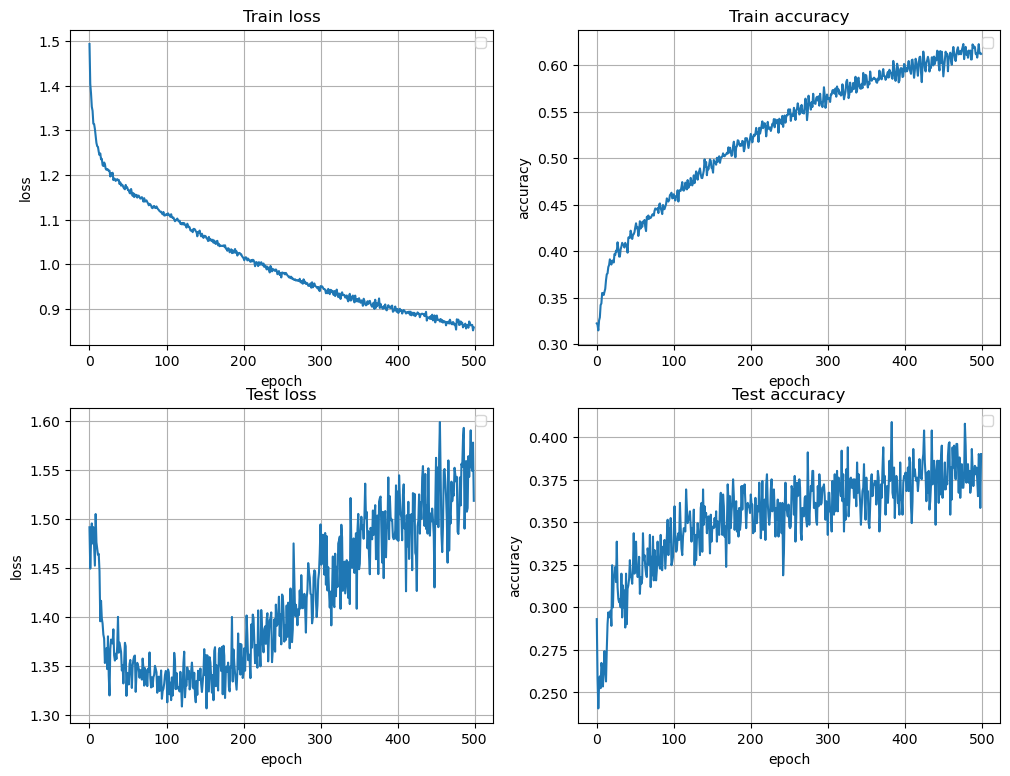

100%|██████████| 500/500 [09:44<00:00,  1.17s/it]


In [22]:
from torch.nn import CrossEntropyLoss

cross_entropy = CrossEntropyLoss(weight=weights)

fit(G, 'random_embs', base_gcn, cross_entropy, n_epochs)

In [23]:
evaluate(base_gcn, 'random_embs')

              precision    recall  f1-score   support

           0       0.88      0.38      0.54       598
           1       0.20      0.39      0.26       142
           2       0.25      0.41      0.31       160
           3       0.37      0.67      0.47       111

    accuracy                           0.42      1011
   macro avg       0.42      0.46      0.39      1011
weighted avg       0.63      0.42      0.45      1011



## Using GraphSAGE

In [24]:
prepare_random_embeddings(G, random_emb_size)

In [ ]:
from GraphSAGE import GraphSAGE

graphsage_model = GraphSAGE(in_feats=G.ndata['random_embs'].shape[1], h_feats=hidden_dim, n_classes=n_classes)

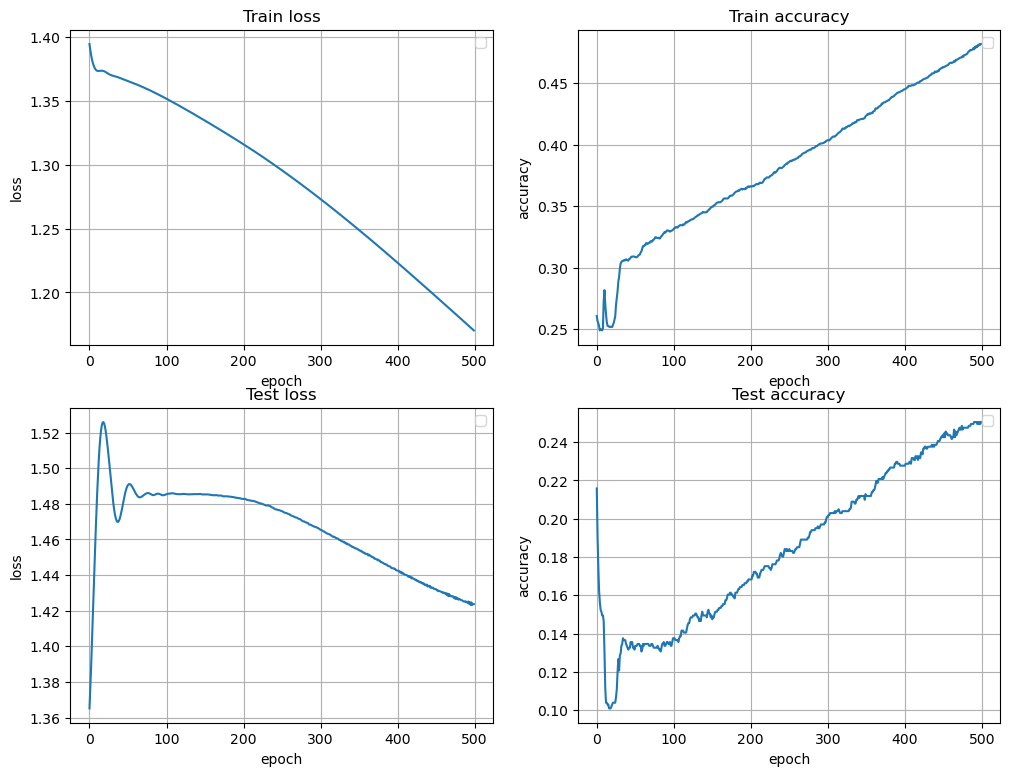

100%|██████████| 500/500 [05:09<00:00,  1.62it/s]


In [26]:
fit(G, 'random_embs', graphsage_model, cross_entropy, n_epochs)

In [27]:
evaluate(graphsage_model, 'random_embs')

              precision    recall  f1-score   support

           0       0.81      0.19      0.30       598
           1       0.12      0.28      0.17       142
           2       0.21      0.31      0.25       160
           3       0.23      0.62      0.33       111

    accuracy                           0.27      1011
   macro avg       0.34      0.35      0.26      1011
weighted avg       0.56      0.27      0.28      1011



## Using GCNwLinear model

In [28]:
prepare_random_embeddings(G, random_emb_size)

In [ ]:
from GCNwLinear import GCNwLinear

gcnwlinear = GCNwLinear(    
    in_feats=G.ndata['random_embs'].shape[1],
    h_feats=hidden_dim,
    num_classes=n_classes,
    num_layers=n_layers,
    dropout=0.5,
)

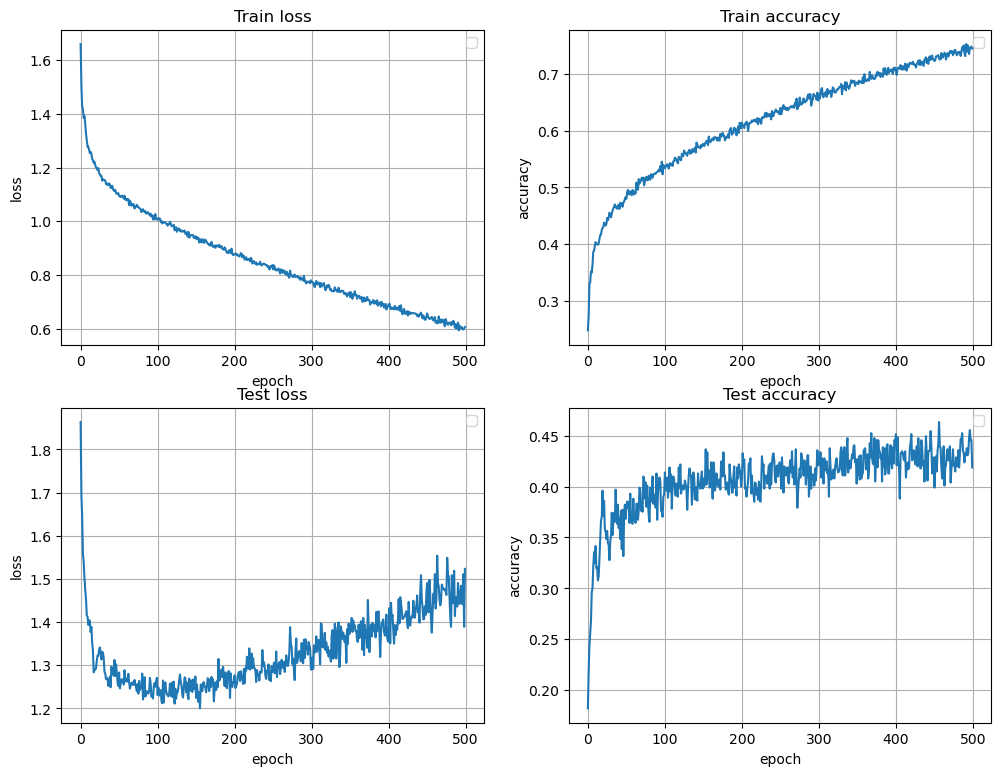

100%|██████████| 500/500 [11:09<00:00,  1.34s/it]


In [30]:
fit(G, 'random_embs', gcnwlinear, cross_entropy, n_epochs)

In [31]:
evaluate(gcnwlinear, 'random_embs')

              precision    recall  f1-score   support

           0       0.83      0.43      0.57       598
           1       0.15      0.32      0.20       142
           2       0.26      0.39      0.31       160
           3       0.49      0.68      0.57       111

    accuracy                           0.44      1011
   macro avg       0.43      0.46      0.41      1011
weighted avg       0.61      0.44      0.48      1011



# Using only text embeddings
## GCN:

In [39]:
import numpy as np

def prepare_text_embs(G, emb_file='embeddings_50.npy'):
    word_embs = np.load(os.path.join(os.pardir, emb_file)).astype('float32')
    word_embs = np.array([word_embs[paper_id2emb_id[paper_id]] for paper_id in nx2dgl.keys()])
    G.ndata['word_embs'] = torch.from_numpy(word_embs)

In [40]:
prepare_text_embs(G)

In [41]:
text_based_gcn = GCN(    
    in_feats=G.ndata['word_embs'].shape[1],
    h_feats=hidden_dim,
    num_classes=n_classes,
    num_layers=n_layers,
    dropout=0.5,
    add_bn=True
)

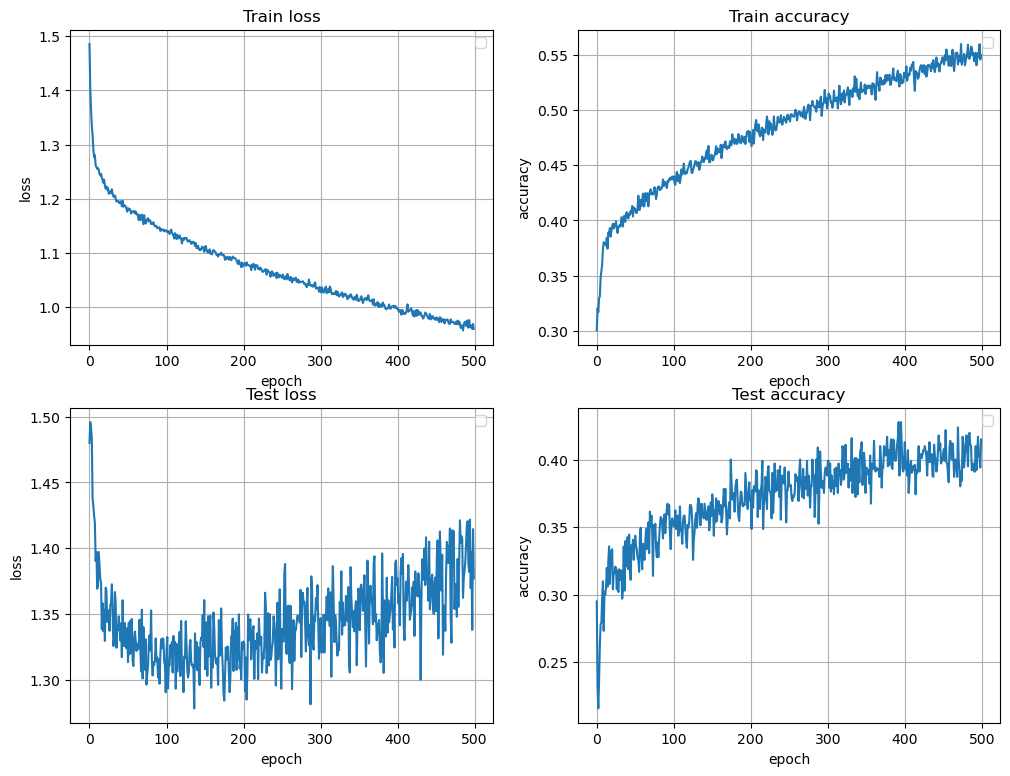

100%|██████████| 500/500 [08:47<00:00,  1.06s/it]


In [42]:
fit(G, 'word_embs', text_based_gcn, cross_entropy, n_epochs)

In [43]:
evaluate(text_based_gcn, 'word_embs')

              precision    recall  f1-score   support

           0       0.87      0.41      0.56       598
           1       0.16      0.33      0.22       142
           2       0.24      0.37      0.29       160
           3       0.38      0.67      0.49       111

    accuracy                           0.42      1011
   macro avg       0.41      0.44      0.39      1011
weighted avg       0.62      0.42      0.46      1011



## GraphSAGE:

In [44]:
text_based_graphsage = GraphSAGE(in_feats=G.ndata['word_embs'].shape[1], h_feats=hidden_dim, n_classes=n_classes)

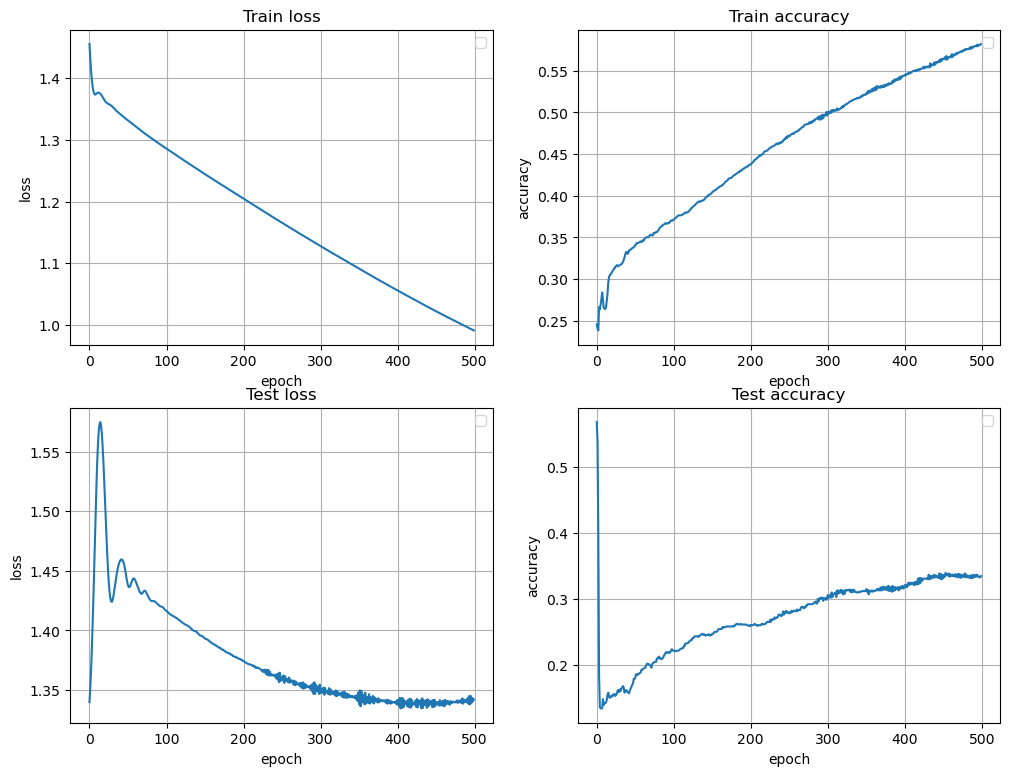

100%|██████████| 500/500 [04:35<00:00,  1.81it/s]


In [45]:
prepare_text_embs(G)
fit(G, 'word_embs', text_based_graphsage, cross_entropy, n_epochs)

In [46]:
evaluate(text_based_graphsage, 'word_embs')

              precision    recall  f1-score   support

           0       0.86      0.32      0.47       598
           1       0.17      0.38      0.24       142
           2       0.20      0.29      0.24       160
           3       0.33      0.74      0.45       111

    accuracy                           0.37      1011
   macro avg       0.39      0.43      0.35      1011
weighted avg       0.60      0.37      0.40      1011



## GCNwLinear:

In [47]:
text_based_gcnwlinear = GCNwLinear(    
    in_feats=G.ndata['word_embs'].shape[1],
    h_feats=hidden_dim,
    num_classes=n_classes,
    num_layers=n_layers,
    dropout=0.5,
)

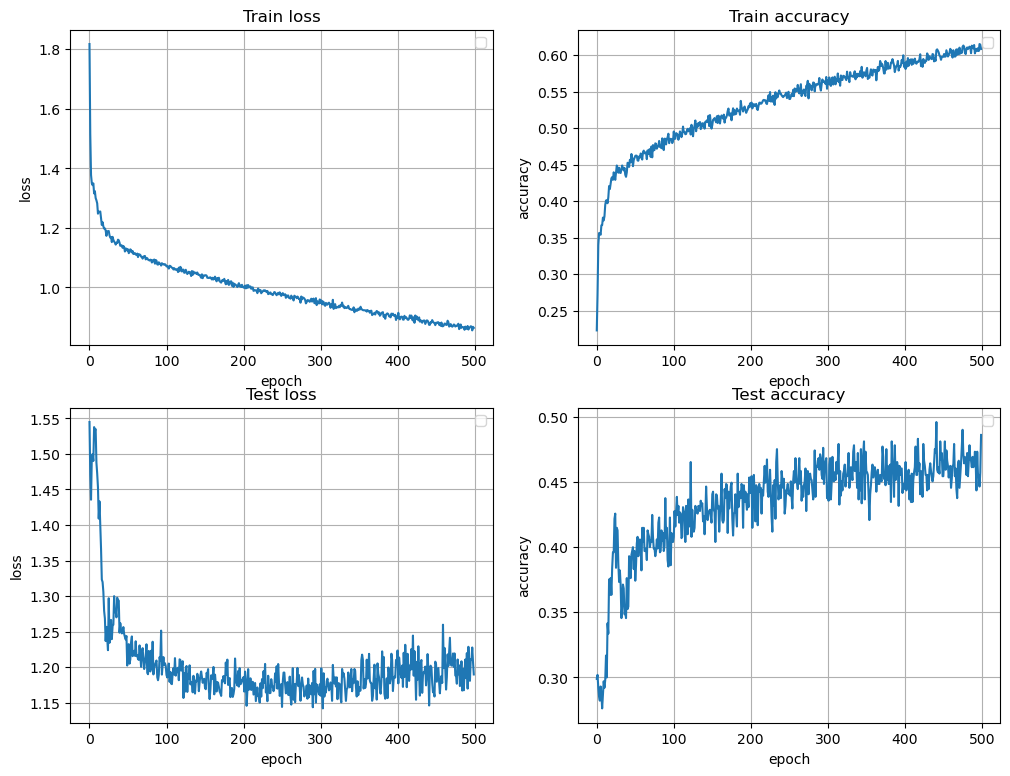

100%|██████████| 500/500 [09:53<00:00,  1.19s/it]


In [48]:
prepare_text_embs(G)
fit(G, 'word_embs', text_based_gcnwlinear, cross_entropy, n_epochs)

In [49]:
evaluate(text_based_graphsage, 'word_embs')

              precision    recall  f1-score   support

           0       0.86      0.32      0.47       598
           1       0.17      0.38      0.24       142
           2       0.20      0.29      0.24       160
           3       0.33      0.74      0.45       111

    accuracy                           0.37      1011
   macro avg       0.39      0.43      0.35      1011
weighted avg       0.60      0.37      0.40      1011



# Using only graph embeddings

In [50]:
from gensim.models import KeyedVectors

def prepare_graph_embs(G, emb_path='n2c_embs'):
    embs_path = os.path.join(os.pardir, emb_path)
    node_embeddings_dict = KeyedVectors.load_word2vec_format(embs_path)
    G.ndata['node_embs'] = torch.tensor(
        [node_embeddings_dict[str(node)] for node in nx2dgl.keys()]
    )

In [51]:
prepare_graph_embs(G)

/tmp/ipykernel_94778/1224283799.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1718618105212/work/torch/csrc/utils/tensor_new.cpp:274.)
  G.ndata['node_embs'] = torch.tensor(


## GCN:

In [52]:
graph_based_gcn = GCN(    
    in_feats=G.ndata['node_embs'].shape[1],
    h_feats=hidden_dim,
    num_classes=n_classes,
    num_layers=n_layers,
    dropout=0.5,
    add_bn=True
)

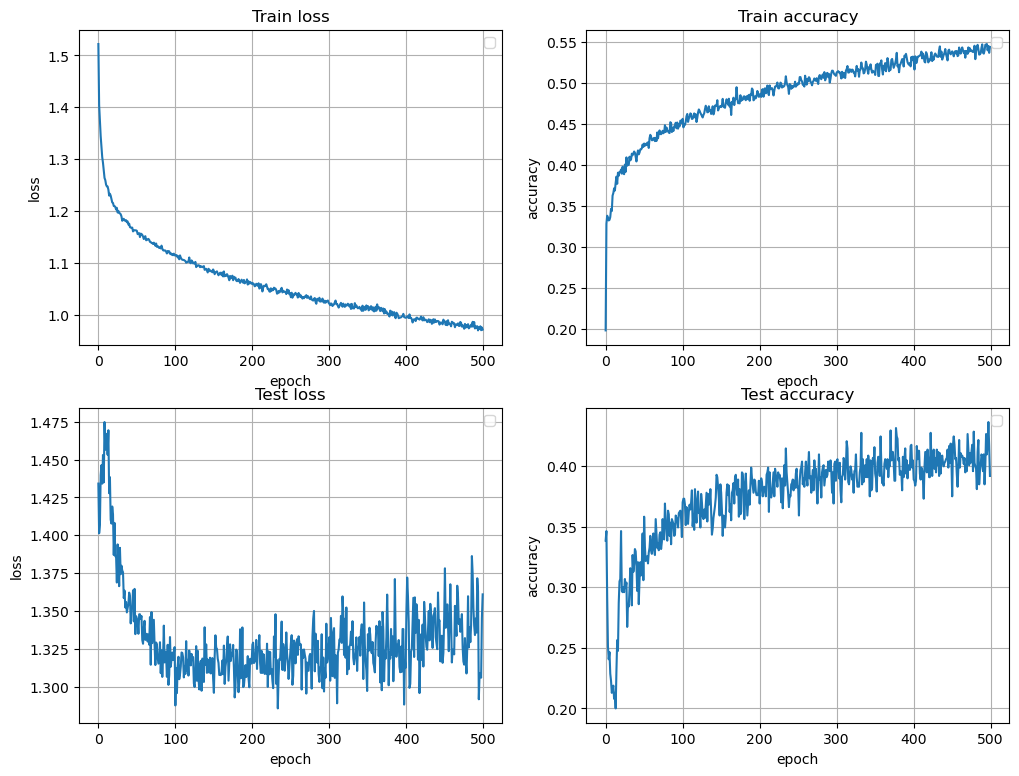

100%|██████████| 500/500 [09:54<00:00,  1.19s/it]


In [53]:
fit(G, 'node_embs', graph_based_gcn, cross_entropy, n_epochs)

In [54]:
evaluate(graph_based_gcn, 'node_embs')

              precision    recall  f1-score   support

           0       0.87      0.40      0.54       598
           1       0.19      0.40      0.25       142
           2       0.22      0.31      0.26       160
           3       0.40      0.77      0.53       111

    accuracy                           0.42      1011
   macro avg       0.42      0.47      0.40      1011
weighted avg       0.62      0.42      0.46      1011



## GraphSAGE:

In [55]:
prepare_graph_embs(G)
graph_based_graphsage = GraphSAGE(in_feats=G.ndata['node_embs'].shape[1], h_feats=hidden_dim, n_classes=n_classes)

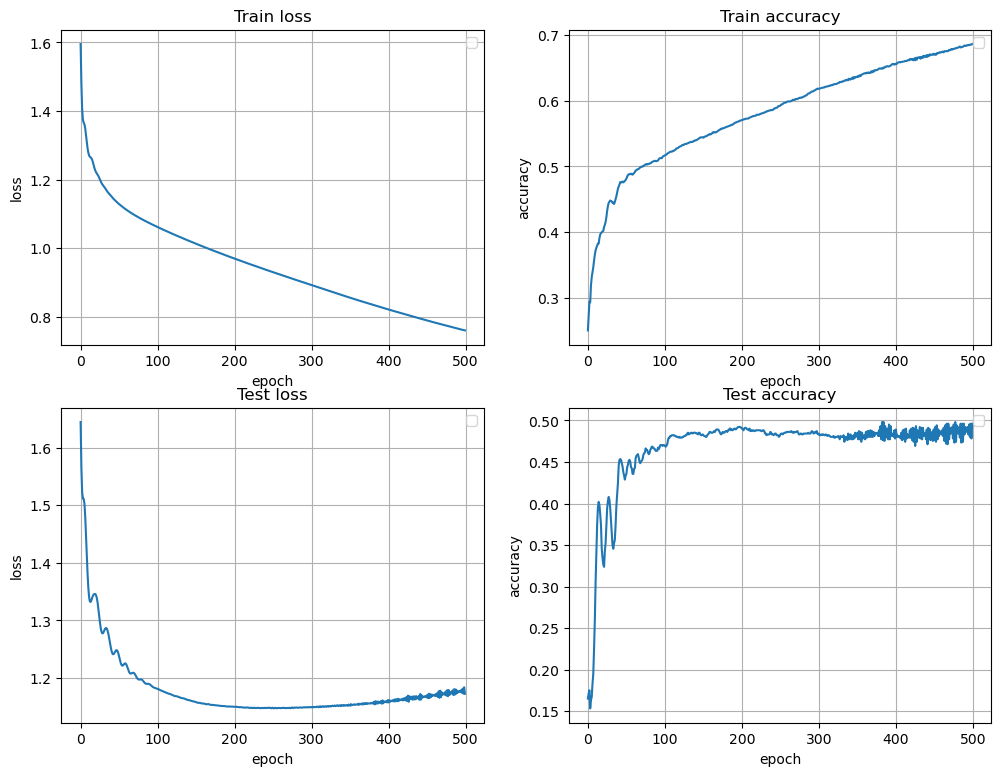

100%|██████████| 500/500 [04:58<00:00,  1.68it/s]


In [56]:
fit(G, 'node_embs', graph_based_graphsage, cross_entropy, n_epochs)

In [58]:
evaluate(graph_based_graphsage, 'node_embs')

              precision    recall  f1-score   support

           0       0.88      0.55      0.68       598
           1       0.20      0.39      0.26       142
           2       0.31      0.38      0.34       160
           3       0.50      0.68      0.57       111

    accuracy                           0.52      1011
   macro avg       0.47      0.50      0.46      1011
weighted avg       0.65      0.52      0.56      1011



## GCNwLinear:

In [59]:
prepare_graph_embs(G)
graph_based_gcnwlinear = GCNwLinear(    
    in_feats=G.ndata['node_embs'].shape[1],
    h_feats=hidden_dim,
    num_classes=n_classes,
    num_layers=n_layers,
    dropout=0.5,
)

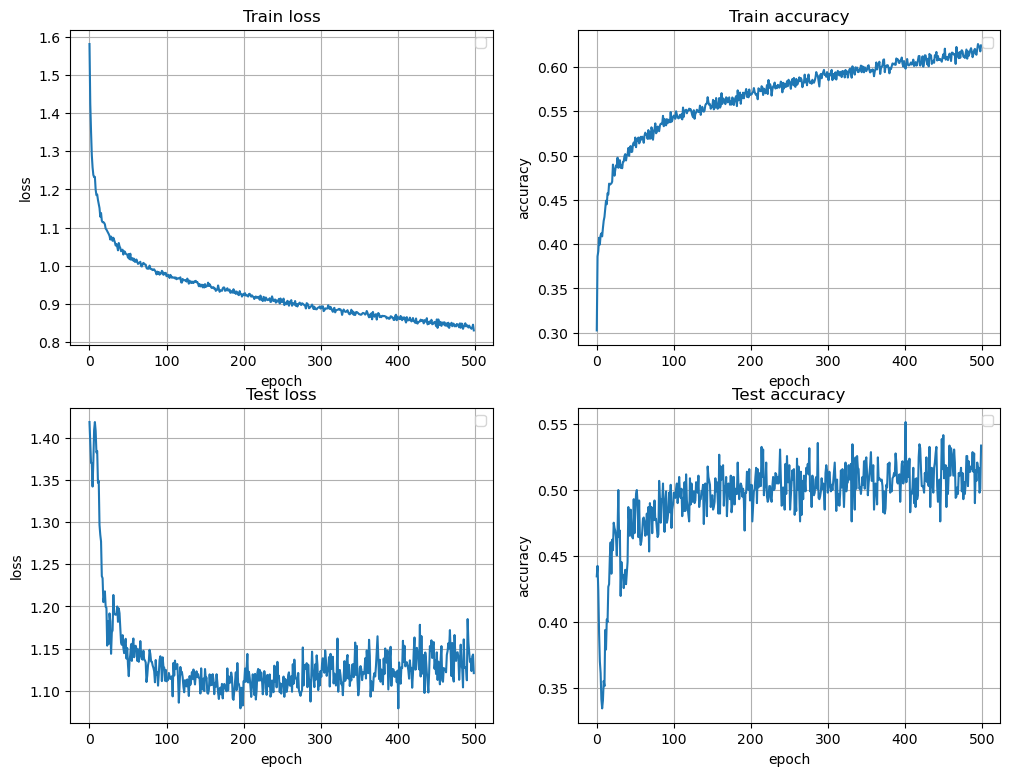

100%|██████████| 500/500 [10:31<00:00,  1.26s/it]


In [60]:
fit(G, 'node_embs', graph_based_gcnwlinear, cross_entropy, n_epochs)

In [61]:
evaluate(graph_based_gcnwlinear, 'node_embs')

              precision    recall  f1-score   support

           0       0.88      0.55      0.68       598
           1       0.20      0.43      0.27       142
           2       0.35      0.44      0.39       160
           3       0.56      0.66      0.60       111

    accuracy                           0.53      1011
   macro avg       0.50      0.52      0.49      1011
weighted avg       0.67      0.53      0.57      1011



# Combine text and graph embeddings

In [62]:
def cat_emb(G, word_emb_path='embeddings_50.npy', node_emb_path='n2c_embs'):
    prepare_graph_embs(G, node_emb_path)
    prepare_text_embs(G, word_emb_path)
    G.ndata['comb_embs'] = torch.cat([G.ndata['word_embs'], G.ndata['node_embs']], dim=1)

In [63]:
cat_emb(G)

In [64]:
cat_based_graphsage = GraphSAGE(in_feats=G.ndata['comb_embs'].shape[1], h_feats=hidden_dim, n_classes=n_classes)

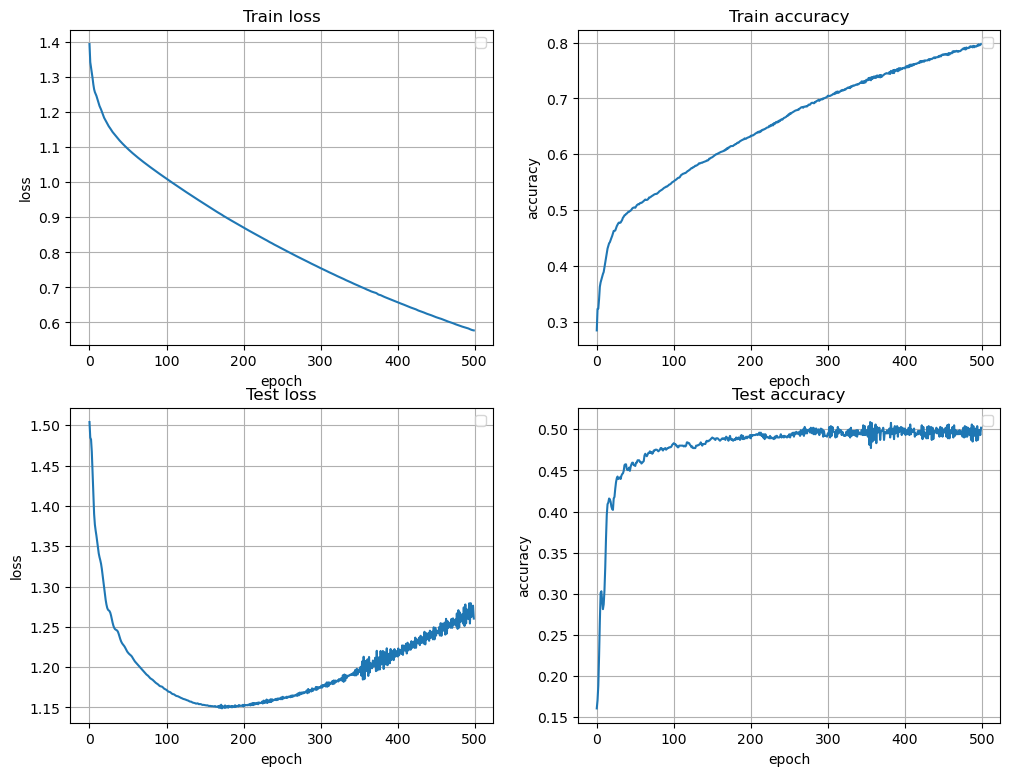

100%|██████████| 500/500 [06:51<00:00,  1.21it/s]


In [65]:
fit(G, 'comb_embs', cat_based_graphsage, cross_entropy, n_epochs)

In [66]:
evaluate(cat_based_graphsage, 'comb_embs')

              precision    recall  f1-score   support

           0       0.88      0.52      0.65       598
           1       0.20      0.39      0.26       142
           2       0.27      0.38      0.32       160
           3       0.49      0.67      0.57       111

    accuracy                           0.50      1011
   macro avg       0.46      0.49      0.45      1011
weighted avg       0.64      0.50      0.54      1011

